In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import pandas as pd
!pip install torchmetrics
!pip install torchmetrics[detection]
!pip install torchvision
!pip install 'ray[tune]'
!pip install -U 'ray[default]'
!pip install -U ipywidgets
!pip install optuna
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.5.1
    Uninstalling ray-2.5.1:
      Successfully uninstalled ray-2.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.5
    Uninstalling widgetsnbextension-3.6.5:
      Successfully uninstalled widgetsnbextension-3.6.5
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.7
    Uninstalling jupyterlab-widgets-3.0.7:
      Successfully uninstalled jupyterlab-widgets-3.0.7
  Attempting uninstall: ipywidgets
    Found existing ins

# Setup W&B and RayTune

In [2]:
import ray
context = ray.init()
print(context.dashboard_url)

2023-10-08 18:45:56,806	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


127.0.0.1:8265


In [3]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("wandb_api")
wandb.login(key=api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# inp = []
# import os
# for dirname, _, filenames in os.walk('/kaggle/input/car-object-detection/data/training_images'):
#     for filename in filenames:
#         pt = os.path.join(dirname, filename)
#         inp.append((filename,plt.imread(pt)))
# inp = dict(inp)
# cls = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
# cls = cls[["image","xmin","ymin","xmax","ymax"]]
# import matplotlib.patches as patches
# for i in range(3):
#     fig,ax=plt.subplots()    
#     bbx= cls.iloc[i]
#     img=inp[bbx["image"]]
#     ax.imshow(img)
#     x = (bbx["xmin"] + bbx["xmax"]) / 2
#     y = (bbx["ymin"] + bbx["ymax"]) / 2
#     # Create a Rectangle patch
#     rect = patches.Rectangle((bbx["xmin"], bbx["ymin"]), bbx["xmax"]-bbx["xmin"], bbx["ymax"]-bbx["ymin"], linewidth=1, edgecolor='r', facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)

#     plt.show()


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Preparing Data And Model

In [6]:
import  os
import pandas as pd
from torchvision.io import read_image
from matplotlib import pyplot as plt
class LocalCarImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        cls = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
        cls = cls[["image","xmin","ymin","xmax","ymax"]]
        self.img_labels = cls
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image =  torchvision.io.read_image(img_path) / 255
        bxs = self.img_labels.query("image == '"+self.img_labels.iloc[idx, 0]+"'").iloc[:,1:].values.copy().tolist()
        label = np.repeat(1,len(bxs)) if len(bxs) > 0 else 0
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, {"boxes": torch.Tensor(bxs),"labels": label}

In [7]:
class LocalCarImageTestDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        for dirname, _, filenames in os.walk('/kaggle/input/car-object-detection/data/testing_images'):
            self.img_labels = filenames
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image =  torchvision.io.read_image(img_path) / 255

        if self.transform:
            image = self.transform(image)
        return image

In [8]:
def collate(batch):
    final_images = []
    dic = {
        'boxes': [],
        'labels': []
    }
    for images,data in batch:
        final_images.append(images)        
        dic["boxes"].append(data["boxes"])     
        dic["labels"].append(data["labels"])
    return final_images,dic

In [9]:
from torch.utils.data import DataLoader
train_dataset = LocalCarImageDataset("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv","/kaggle/input/car-object-detection/data/training_images")
test_dataset = LocalCarImageTestDataset(None,"/kaggle/input/car-object-detection/data/testing_images")
train_set, val_set = torch.utils.data.random_split(train_dataset, [0.85,0.15])

train_gen = DataLoader(train_set,shuffle=True,batch_size=16,collate_fn=collate)
valid_gen = DataLoader(train_set,shuffle=True,batch_size=16,collate_fn=collate)
test_gen = DataLoader(test_dataset,shuffle=True,batch_size=2)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device ! - {device}")

Device ! - cuda


In [11]:
import torchvision
from ray import tune
from ray.tune import Trainable
from torchmetrics.detection.mean_ap import MeanAveragePrecision 
import gc
from matplotlib.patches import Rectangle
import numpy as np  
import matplotlib.pyplot as plt  
from matplotlib import patches

# model = 
#model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features,2)

# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights= torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1,trainable_backbone_layers=1)

# n_epochs = 5

class FastRCNNCars():
    def __init__(self,params=None,hopt=False,report_wb=False):
        if params == None:
            params = {
                "lr": 0.0005,
                "n_epoch": 2
            }
        self.params = params
        self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='COCO_V1',trainable_backbone_layers=0)
        self.model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(self.model.roi_heads.box_predictor.cls_score.in_features,2)
        self.metric = MeanAveragePrecision()
        self.val_metric = MeanAveragePrecision()
        self.hopt = hopt
        self.report_wb = report_wb
        self.opt = torch.optim.Adam(params=self.model.parameters(),lr=params["lr"])
#         self.loss = torch.nn.CrossEntropyLoss()
        self.n_epochs = params["n_epoch"]

    def preprocessBatch(images,labels):
        x_train_batch = []
        y_train = []
        for bx,label in list(zip(labels["boxes"],labels["labels"])):

            y_train.append({
                "boxes": bx.view(-1,4).to(device),
                "labels": torch.Tensor(label).long().to(device)
            })

        for img in images:
            x_train_batch.append(img.to(device))
            
        return x_train_batch,y_train
    
    def predict(self,pred_gen):
        self.model.to(device)
        self.model.eval()
        pred_set = iter(pred_gen)

        with torch.no_grad():
            for imgs in pred_set:
                x = list(map(lambda d: d.to(device),imgs))
                res=self.model(x)
                for idx,instance in enumerate(res):
                    tt = imgs[idx].to('cpu')
                    data = list(zip(instance["boxes"],instance["scores"]))
                    keep = torchvision.ops.nms(instance["boxes"],instance["scores"],0.1)
                    data = [data[i] for i in keep]
                    fig,ax=plt.subplots()    

                    for dc in data:
                        bbx=dc[0].to('cpu')
                        bbx = pd.Series({"xmin": bbx[0].item(),"ymin": bbx[1].item(),"xmax": bbx[2].item(),"ymax": bbx[3].item()})
                        ax.imshow(tt.permute(1, 2, 0).numpy())
                        x = (bbx["xmin"] + bbx["xmax"]) / 2
                        y = (bbx["ymin"] + bbx["ymax"]) / 2
                #         # Create a Rectangle patch
                        rect = patches.Rectangle((bbx["xmin"], bbx["ymin"]), bbx["xmax"]-bbx["xmin"], bbx["ymax"]-bbx["ymin"], linewidth=1, edgecolor='r', facecolor='none')
                        print(f"Score : [{dc[1]}]")
                #         # Add the patch to the Axes
                        ax.add_patch(rect)

                    plt.show()
                    yield data

    def train(self,train_gen,valid_gen=None):
        
        name = ray.train.get_context().get_trial_name()
        
        if(self.report_wb):
            if(self.hopt):
                wandb.init(project="FRCNN tuning cars",group="hopt_2",config={**self.params},name=name)
            else:
                wandb.init(project="FRCNN tuning cars",group="Training",config={**self.params})
                
        train_metric_results = []
        valid_metric_results = []

        if(device == 'cuda'):
            torch.cuda.empty_cache()
        self.model.train()
        self.model=self.model.to(device)
        for e in range(self.n_epochs):
            
            #Init for Debugging
            epoch_loss = 0
            loss_classifier = 0
            loss_box_reg = 0
            loss_objectness = 0
            self.metric.reset()

            
            #Prepare Batches
            X_train = iter(train_gen)
            for images,labels in X_train:
                
                self.model.train()
                
                #Preprocess Batch
                x_train_batch,y_train = FastRCNNCars.preprocessBatch(images,labels)

                # Train and backpro
                loss_dict = self.model(x_train_batch,y_train)
                l = torch.Tensor(loss_dict["loss_classifier"]+loss_dict["loss_box_reg"]+loss_dict["loss_objectness"]).sum()
                l.backward()

                self.opt.step()
                self.opt.zero_grad()

                # Monitor Performance
                
                epoch_loss+= l 
                loss_classifier += loss_dict["loss_classifier"]
                loss_box_reg += loss_dict["loss_box_reg"]
                loss_objectness += loss_dict["loss_objectness"]
                with torch.no_grad():
                    self.model.eval()
                    preds = self.model(x_train_batch)
                    acc = self.metric(preds, y_train)
                    
            # Train Metrics And Reporting    
            train_met = self.metric.compute()

            hopt_metrics = {"train.loss": epoch_loss.item(), "train.map": train_met['map'].to("cpu").item()}
                
            train_metric_results.append({
                "epoch": e,
                "loss": epoch_loss,
                "loss_classifier": loss_classifier,
                "loss_box_reg": loss_box_reg,
                "loss_objectness": loss_objectness,
                **train_met
            })
            
            # Report To W&B
            if(self.report_wb):
                wandb.log(train_metric_results[-1])
            
            print(f"Epoch - {e} : Loss : [{epoch_loss}] - Metric : [{train_met['map']}] - loss_classifier : [{loss_classifier}] - loss_box_reg : [{loss_box_reg}] - loss_objectness : [{loss_objectness}]")
            
            del X_train
            gc.collect()
            
            # Validation Reporting
            if(valid_gen):
                
                self.val_metric.reset()
                
                #Prepare Validation Batches
                X_valid = iter(valid_gen)
                
                self.model.eval()
                for images,labels in X_valid:

                    #Preprocess Batch
                    x_valid_batch,y_valid = FastRCNNCars.preprocessBatch(images,labels)
                    
                    with torch.no_grad():
                        
                        # Eval
                        preds = self.model(x_valid_batch)
                        
                        # Report Metric
                        acc = self.val_metric(preds, y_valid)
                    
                # Train Metrics And Reporting    
                valid_metrics = self.val_metric.compute()
                
                if(self.hopt):
                    hopt_metrics = {**hopt_metrics,**{"valid.map": valid_metrics['map'].to("cpu").item()}}
                    
                # Report To W&B
                if(self.report_wb):
                    wandb.log(dict([("valid_epoch",e)]+[("valid_"+key,val) for key,val in valid_metrics.items()]))
                
                print(f"Validation : Epoch - {e} : Metric : [{valid_metrics['map']}]")
                
            
            if(self.hopt):
                    train.report(hopt_metrics) 
                    
        # CleanUp Phase
        if(self.report_wb):
            wandb.finish()

        return train_metric_results


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# HOPT using RayTune and report to W&B

In [12]:
from ray import tune , train
from ray.tune.schedulers import ASHAScheduler
from matplotlib.patches import Rectangle

def train_model(params):
    cars = FastRCNNCars(params,True,True)
#     loaded_checkpoint = train.get_checkpoint()
#     if loaded_checkpoint:
#         with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
#             model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
#         cars.model.load_state_dict(model_state)
#         cars.opt.load_state_dict(optimizer_state)
    rs=cars.train(train_gen,valid_gen)

In [13]:
from ray.tune.search.optuna import OptunaSearch

config={
       "lr":tune.uniform(0.0001,0.001),
       "n_epoch": tune.choice([5,10,13,16,19,23,25,27,30])
    }
scheduler = ASHAScheduler(
    max_t=20,
    grace_period=5,
    reduction_factor=2
)
algo = OptunaSearch()
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_model),
        resources={"gpu": 1}
    ),
    tune_config=tune.TuneConfig(
        metric="valid.map",
        mode="max",
        search_alg = algo,
        scheduler=scheduler,
        num_samples=10,
    ),
    param_space=config,
)
results = tuner.fit()

best_result = results.get_best_result("valid.map", "max")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(
    best_result.metrics["train.loss"]))
print("Best trial final validation accuracy: {}".format(
    best_result.metrics["valid.map"]))




(pid=278) /opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
(pid=278)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(train_model pid=278) Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
  0%|          | 0.00/74.2M [00:00<?, ?B/s]
  9%|▉         | 6.87M/74.2M [00:00<00:01, 65.0MB/s]
 21%|██        | 15.6M/74.2M [00:00<00:00, 79.8MB/s]
 34%|███▍      | 25.6M/74.2M [00:00<00:00, 88.6MB/s]
 52%|█████▏    | 38.3M/74.2M [00:00<00:00, 106MB/s] 
 72%|███████▏  | 53.5M/74.2M [00:00<00:00, 125MB/s]
100%|██████████| 74.2M/74.2M [00:00<00:00, 122MB/s]
(train_model pid=278) wandb: Currently logged in as: dbzadnen. Use `wandb login --relogin` to force relogin
(pid=307) /opt/conda/lib/python3.10/site-packages/scipy/_

(train_model pid=278) Epoch - 0 : Loss : [33.469329833984375] - Metric : [0.5403367280960083] - loss_classifier : [10.383158683776855] - loss_box_reg : [22.969127655029297] - loss_objectness : [0.11704424023628235]
(train_model pid=278) Validation : Epoch - 0 : Metric : [0.6282601356506348]
(train_model pid=307) Epoch - 0 : Loss : [32.88655471801758] - Metric : [0.46905410289764404] - loss_classifier : [13.374741554260254] - loss_box_reg : [19.321083068847656] - loss_objectness : [0.1907268911600113]
(train_model pid=278) Epoch - 1 : Loss : [18.90787696838379] - Metric : [0.6680414080619812] - loss_classifier : [6.188161849975586] - loss_box_reg : [12.673660278320312] - loss_objectness : [0.046054136008024216]
(train_model pid=307) Validation : Epoch - 0 : Metric : [0.5505519509315491]
(train_model pid=278) Validation : Epoch - 1 : Metric : [0.7000943422317505]
(train_model pid=307) Epoch - 1 : Loss : [20.48151969909668] - Metric : [0.6167581081390381] - loss_classifier : [7.0268177986

(train_model pid=278) wandb: Waiting for W&B process to finish... (success).
(train_model pid=278) wandb: - 0.002 MB of 0.002 MB uploaded (0.000 MB deduped)
(train_model pid=278) wandb: \ 0.002 MB of 0.002 MB uploaded (0.000 MB deduped)
(train_model pid=278) wandb: 
(train_model pid=278) wandb: Run history:
(train_model pid=278) wandb:                 classes ▁▁▁▁▁
(train_model pid=278) wandb:                   epoch ▁▃▅▆█
(train_model pid=278) wandb:                    loss █▃▂▂▁
(train_model pid=278) wandb:            loss_box_reg █▃▂▂▁
(train_model pid=278) wandb:         loss_classifier █▃▂▁▁
(train_model pid=278) wandb:         loss_objectness █▃▂▁▁
(train_model pid=278) wandb:                     map ▁▅▇▇█
(train_model pid=278) wandb:                  map_50 ▁▇██▇
(train_model pid=278) wandb:                  map_75 ▁▆▇██
(train_model pid=278) wandb:               map_large ▁▇▇██
(train_model pid=278) wandb:              map_medium ▁▅▆▇█
(train_model pid=278) wandb:           map

(train_model pid=307) Epoch - 0 : Loss : [29.886096954345703] - Metric : [0.6078575253486633] - loss_classifier : [8.577576637268066] - loss_box_reg : [21.23838233947754] - loss_objectness : [0.07013483345508575]
(train_model pid=307) Validation : Epoch - 4 : Metric : [0.665757417678833]


(train_model pid=278) wandb: wandb version 0.15.12 is available!  To upgrade, please run:
(train_model pid=278) wandb:  $ pip install wandb --upgrade
(train_model pid=278) wandb: Tracking run with wandb version 0.15.9
(train_model pid=278) wandb: Run data is saved locally in /root/ray_results/train_model_2023-10-08_18-46-25/train_model_a58f1ddd_4_lr=0.0009,n_epoch=23_2023-10-08_18-51-33/wandb/run-20231008_185136-quwvtxpu
(train_model pid=278) wandb: Run `wandb offline` to turn off syncing.
(train_model pid=278) wandb: Syncing run train_model_a58f1ddd
(train_model pid=278) wandb: ⭐️ View project at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars
(train_model pid=278) wandb: 🚀 View run at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars/runs/quwvtxpu


(train_model pid=307) Validation : Epoch - 0 : Metric : [0.6628148555755615]
(train_model pid=278) Epoch - 0 : Loss : [31.8800048828125] - Metric : [0.45570650696754456] - loss_classifier : [12.399930953979492] - loss_box_reg : [19.3349609375] - loss_objectness : [0.14511531591415405]
(train_model pid=307) Epoch - 1 : Loss : [29.187076568603516] - Metric : [0.6865620017051697] - loss_classifier : [6.7714385986328125] - loss_box_reg : [22.39520835876465] - loss_objectness : [0.020431598648428917]
(train_model pid=278) Validation : Epoch - 0 : Metric : [0.5247754454612732]
(train_model pid=307) Validation : Epoch - 1 : Metric : [0.7376804351806641]
(train_model pid=278) Epoch - 1 : Loss : [16.41261863708496] - Metric : [0.5966221690177917] - loss_classifier : [5.856104373931885] - loss_box_reg : [10.48405933380127] - loss_objectness : [0.0724569782614708]
(train_model pid=307) Epoch - 2 : Loss : [24.774999618530273] - Metric : [0.7387158870697021] - loss_classifier : [6.570751190185547] 

(train_model pid=278) wandb: Waiting for W&B process to finish... (success).
(train_model pid=278) wandb: - 0.002 MB of 0.002 MB uploaded (0.000 MB deduped)
(train_model pid=278) wandb: \ 0.002 MB of 0.002 MB uploaded (0.000 MB deduped)
(train_model pid=278) wandb: 
(train_model pid=278) wandb: Run history:
(train_model pid=278) wandb:                 classes ▁▁▁▁▁▁▁▁▁▁
(train_model pid=278) wandb:                   epoch ▁▃▅▆█▁▃▅▆█
(train_model pid=278) wandb:                    loss █▄▂▁▁█▆▆▅▄
(train_model pid=278) wandb:            loss_box_reg ▇▄▂▁▁█▇▇▆▅
(train_model pid=278) wandb:         loss_classifier █▃▃▁▁▅▄▃▃▃
(train_model pid=278) wandb:         loss_objectness █▄▃▅▃▄▁▁▁▁
(train_model pid=278) wandb:                     map ▁▄▅▅▅▄▆▇██
(train_model pid=278) wandb:                  map_50 ▁▇▇▇▇▇▇▇█▇
(train_model pid=278) wandb:                  map_75 ▁▅▆▆▆▅▇▇██
(train_model pid=278) wandb:               map_large ▁▄▆▅▆▅▇▇██
(train_model pid=278) wandb:              map_mediu

(train_model pid=307) Epoch - 11 : Loss : [9.499385833740234] - Metric : [0.9039272665977478] - loss_classifier : [3.6731104850769043] - loss_box_reg : [5.818388938903809] - loss_objectness : [0.007885877974331379]
(train_model pid=307) Validation : Epoch - 10 : Metric : [0.8957451581954956]


(train_model pid=278) wandb: wandb version 0.15.12 is available!  To upgrade, please run:
(train_model pid=278) wandb:  $ pip install wandb --upgrade
(train_model pid=278) wandb: Tracking run with wandb version 0.15.9
(train_model pid=278) wandb: Run data is saved locally in /root/ray_results/train_model_2023-10-08_18-46-25/train_model_550148da_6_lr=0.0001,n_epoch=23_2023-10-08_18-56-12/wandb/run-20231008_190009-8221blp2
(train_model pid=278) wandb: Run `wandb offline` to turn off syncing.
(train_model pid=278) wandb: Syncing run train_model_550148da
(train_model pid=278) wandb: ⭐️ View project at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars
(train_model pid=278) wandb: 🚀 View run at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars/runs/8221blp2


(train_model pid=307) Validation : Epoch - 11 : Metric : [0.9053707718849182]
(train_model pid=278) Epoch - 0 : Loss : [29.410892486572266] - Metric : [0.5851569771766663] - loss_classifier : [8.284455299377441] - loss_box_reg : [21.049957275390625] - loss_objectness : [0.0764777883887291]
(train_model pid=307) Epoch - 12 : Loss : [9.494255065917969] - Metric : [0.8997846841812134] - loss_classifier : [3.606821298599243] - loss_box_reg : [5.882387161254883] - loss_objectness : [0.005045625846832991]
(train_model pid=278) Validation : Epoch - 0 : Metric : [0.6612232327461243]
(train_model pid=307) Validation : Epoch - 12 : Metric : [0.8854922652244568]
(train_model pid=278) Epoch - 1 : Loss : [26.085054397583008] - Metric : [0.6996087431907654] - loss_classifier : [6.884832859039307] - loss_box_reg : [19.164831161499023] - loss_objectness : [0.03538432717323303]
(train_model pid=307) Epoch - 13 : Loss : [8.743159294128418] - Metric : [0.9034076929092407] - loss_classifier : [3.567342519

(train_model pid=307) wandb: Waiting for W&B process to finish... (success).


(train_model pid=307) Validation : Epoch - 18 : Metric : [0.9275752902030945]


(train_model pid=307) wandb: 
(train_model pid=307) wandb: Run history:
(train_model pid=307) wandb:                 classes ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(train_model pid=307) wandb:                   epoch ▁▁▂▂▃▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
(train_model pid=307) wandb:                    loss █▅▃▂▂▇▇▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
(train_model pid=307) wandb:            loss_box_reg ▇▅▃▂▂██▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
(train_model pid=307) wandb:         loss_classifier █▄▂▂▁▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
(train_model pid=307) wandb:         loss_objectness █▃▃▂▃▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(train_model pid=307) wandb:                     map ▁▃▄▄▄▃▄▅▆▆▆▇▇▇▇▇█▇▇█████
(train_model pid=307) wandb:                  map_50 ▁▇▇▇▇▆████▇▇▇▇█▇█▇▇▇▇▇▇▇
(train_model pid=307) wandb:                  map_75 ▁▅▆▆▆▅▆▇████████████████
(train_model pid=307) wandb:               map_large ▁▄▄▄▄▃▄▅▅▆▆▇▇▇▇▇▇▇▇█▇███
(train_model pid=307) wandb:              map_medium ▁▃▄▄▄▃▄▅▆▆▆▇▇▇▇▇█▇▇█████
(train_model pid=307) wandb:           map_per_class ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

(train_model pid=278) Epoch - 7 : Loss : [14.313281059265137] - Metric : [0.8562732934951782] - loss_classifier : [4.422563552856445] - loss_box_reg : [9.883362770080566] - loss_objectness : [0.007353500463068485]
(train_model pid=278) Validation : Epoch - 7 : Metric : [0.8620830178260803]


(train_model pid=307) wandb: wandb version 0.15.12 is available!  To upgrade, please run:
(train_model pid=307) wandb:  $ pip install wandb --upgrade
(train_model pid=307) wandb: Tracking run with wandb version 0.15.9
(train_model pid=307) wandb: Run data is saved locally in /root/ray_results/train_model_2023-10-08_18-46-25/train_model_d6466c7c_7_lr=0.0002,n_epoch=5_2023-10-08_19-00-08/wandb/run-20231008_190629-gcwa8sxx
(train_model pid=307) wandb: Run `wandb offline` to turn off syncing.
(train_model pid=307) wandb: Syncing run train_model_d6466c7c
(train_model pid=307) wandb: ⭐️ View project at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars
(train_model pid=307) wandb: 🚀 View run at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars/runs/gcwa8sxx


(train_model pid=278) Epoch - 8 : Loss : [12.634997367858887] - Metric : [0.8724265098571777] - loss_classifier : [4.140379428863525] - loss_box_reg : [8.479938507080078] - loss_objectness : [0.01467869058251381]
(train_model pid=278) Validation : Epoch - 8 : Metric : [0.8742097020149231]
(train_model pid=307) Epoch - 0 : Loss : [29.07555389404297] - Metric : [0.5748206377029419] - loss_classifier : [8.087779998779297] - loss_box_reg : [20.917165756225586] - loss_objectness : [0.07060664147138596]
(train_model pid=278) Epoch - 9 : Loss : [11.811259269714355] - Metric : [0.8861922025680542] - loss_classifier : [4.221154689788818] - loss_box_reg : [7.58170747756958] - loss_objectness : [0.008395794779062271]
(train_model pid=307) Validation : Epoch - 0 : Metric : [0.6609089374542236]
(train_model pid=278) Validation : Epoch - 9 : Metric : [0.867350161075592]
(train_model pid=307) Epoch - 1 : Loss : [28.286996841430664] - Metric : [0.6874201893806458] - loss_classifier : [7.08356952667236

(train_model pid=307) wandb: Waiting for W&B process to finish... (success).


(train_model pid=307) Validation : Epoch - 4 : Metric : [0.818766176700592]


(train_model pid=307) wandb: 
(train_model pid=307) wandb: Run history:
(train_model pid=307) wandb:                 classes ▁▁▁▁▁
(train_model pid=307) wandb:                   epoch ▁▃▅▆█
(train_model pid=307) wandb:                    loss ██▅▃▁
(train_model pid=307) wandb:            loss_box_reg ██▆▄▁
(train_model pid=307) wandb:         loss_classifier █▆▃▃▁
(train_model pid=307) wandb:         loss_objectness █▃▂▁▁
(train_model pid=307) wandb:                     map ▁▄▆▇█
(train_model pid=307) wandb:                  map_50 ▁████
(train_model pid=307) wandb:                  map_75 ▁▆▇██
(train_model pid=307) wandb:               map_large ▁▅▆▇█
(train_model pid=307) wandb:              map_medium ▁▄▆▇█
(train_model pid=307) wandb:           map_per_class ▁▁▁▁▁
(train_model pid=307) wandb:               map_small ▁▄▅▇█
(train_model pid=307) wandb:                   mar_1 ▁▅▆▇█
(train_model pid=307) wandb:                  mar_10 ▁▄▆▇█
(train_model pid=307) wandb:               

(train_model pid=278) Validation : Epoch - 2 : Metric : [0.5913137793540955]


(train_model pid=307) wandb: wandb version 0.15.12 is available!  To upgrade, please run:
(train_model pid=307) wandb:  $ pip install wandb --upgrade
(train_model pid=307) wandb: Tracking run with wandb version 0.15.9
(train_model pid=307) wandb: Run data is saved locally in /root/ray_results/train_model_2023-10-08_18-46-25/train_model_636fbff4_9_lr=0.0004,n_epoch=16_2023-10-08_19-08-41/wandb/run-20231008_191102-g5ghjloe
(train_model pid=307) wandb: Run `wandb offline` to turn off syncing.
(train_model pid=307) wandb: Syncing run train_model_636fbff4
(train_model pid=307) wandb: ⭐️ View project at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars
(train_model pid=307) wandb: 🚀 View run at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars/runs/g5ghjloe


(train_model pid=278) Epoch - 3 : Loss : [4.5450239181518555] - Metric : [0.5741403102874756] - loss_classifier : [1.8467811346054077] - loss_box_reg : [2.6527583599090576] - loss_objectness : [0.04548529163002968]
(train_model pid=278) Validation : Epoch - 3 : Metric : [0.5256151556968689]
(train_model pid=307) Epoch - 0 : Loss : [30.64369010925293] - Metric : [0.5831589698791504] - loss_classifier : [9.82251262664795] - loss_box_reg : [20.73499870300293] - loss_objectness : [0.08618111163377762]
(train_model pid=307) Validation : Epoch - 0 : Metric : [0.6503273248672485]
(train_model pid=278) Epoch - 4 : Loss : [4.046659469604492] - Metric : [0.5728162527084351] - loss_classifier : [1.5443769693374634] - loss_box_reg : [2.4734153747558594] - loss_objectness : [0.02886788360774517]
(train_model pid=278) Validation : Epoch - 4 : Metric : [0.5091128945350647]
(train_model pid=307) Epoch - 1 : Loss : [26.18412208557129] - Metric : [0.6708265542984009] - loss_classifier : [7.3977198600769

2023-10-08 19:20:26,904	INFO tune.py:1143 -- Total run time: 2041.05 seconds (2032.43 seconds for the tuning loop).


(train_model pid=278) Validation : Epoch - 9 : Metric : [0.8453493118286133]
Best trial config: {'lr': 0.0001876624905714725, 'n_epoch': 19}
Best trial final validation loss: 5.8208088874816895
Best trial final validation accuracy: 0.9275752902030945


In [14]:
best_result.config

{'lr': 0.0001876624905714725, 'n_epoch': 19}

# Model Selection And Evaluation

In [15]:
print(device)
cars = FastRCNNCars(best_result.config,False,True)
rs=cars.train(train_gen,valid_gen)

cuda


/opt/conda/lib/python3.10/site-packages/ray/train/_internal/session.py:829: UserWarning: `get_trial_name` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(
wandb: Currently logged in as: dbzadnen. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231008_192028-b29es8vs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run devoted-haze-65
wandb: ⭐️ View project at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars
wandb: 🚀 View run at https://wandb.ai/dbzadnen/FRCNN%20tuning%20cars/runs/b29es8vs


Epoch - 0 : Loss : [27.19955062866211] - Metric : [0.5900640487670898] - loss_classifier : [8.117696762084961] - loss_box_reg : [18.995277404785156] - loss_objectness : [0.08657369762659073]
Validation : Epoch - 0 : Metric : [0.6465079188346863]
Epoch - 1 : Loss : [24.913330078125] - Metric : [0.6906106472015381] - loss_classifier : [5.51135778427124] - loss_box_reg : [19.374801635742188] - loss_objectness : [0.02717624232172966]
Validation : Epoch - 1 : Metric : [0.6915066838264465]
Epoch - 2 : Loss : [24.845458984375] - Metric : [0.7356550097465515] - loss_classifier : [5.689123153686523] - loss_box_reg : [19.139984130859375] - loss_objectness : [0.016351336613297462]
Validation : Epoch - 2 : Metric : [0.7477174997329712]
Epoch - 3 : Loss : [22.470909118652344] - Metric : [0.7642236351966858] - loss_classifier : [5.2045512199401855] - loss_box_reg : [17.254255294799805] - loss_objectness : [0.012106234207749367]
Validation : Epoch - 3 : Metric : [0.780550479888916]
Epoch - 4 : Loss :

wandb: Waiting for W&B process to finish... (success).


Validation : Epoch - 18 : Metric : [0.9151062369346619]


wandb: 
wandb: Run history:
wandb:                 classes ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   epoch ▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
wandb:                    loss █▇▇▆▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁
wandb:            loss_box_reg ███▇▆▄▄▄▃▃▂▂▁▁▁▁▁▁▁
wandb:         loss_classifier █▄▅▄▃▃▃▂▂▂▂▂▁▁▁▁▂▁▁
wandb:         loss_objectness █▃▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁
wandb:                     map ▁▃▄▄▅▆▆▆▇▇▇▇███████
wandb:                  map_50 ▁▆███████▆▆▆▆▆▆▆▆▆▆
wandb:                  map_75 ▁▆▇▇▇██████████████
wandb:               map_large ▁▂▃▄▄▅▆▆▆▇▇▇██████▇
wandb:              map_medium ▁▃▄▄▅▆▆▆▇▇▇▇███████
wandb:           map_per_class ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               map_small ▁▅▆▆▇▇▇██▇▇▇▇▇███▇▇
wandb:                   mar_1 ▁▃▃▄▅▅▆▆▇▇▇▇███████
wandb:                  mar_10 ▁▃▄▅▆▆▆▇▇▇█▇███████
wandb:                 mar_100 ▁▃▄▅▅▆▆▇▇▇█▇███████
wandb:       mar_100_per_class ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               mar_large ▁▃▄▄▅▆▆▆▇▇▇▇██████▇
wandb:              mar_medium ▁▃▄▅▅▆▆▆▇▇▇▇███████
wan

In [16]:
preds=cars.predict(test_gen)

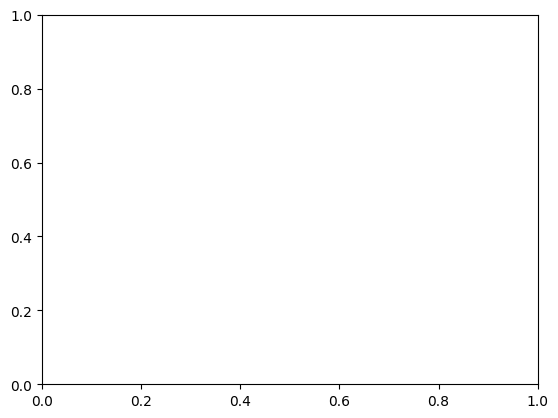

Score : [0.9994624257087708]


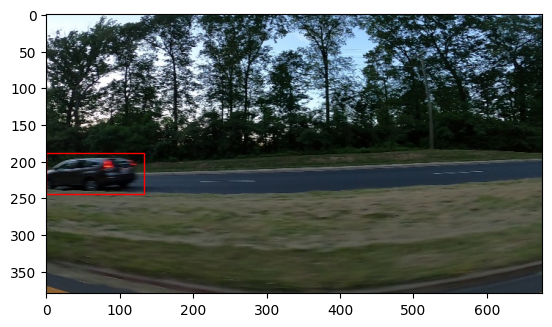

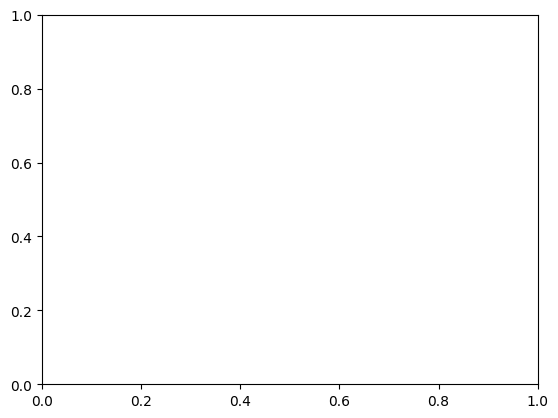

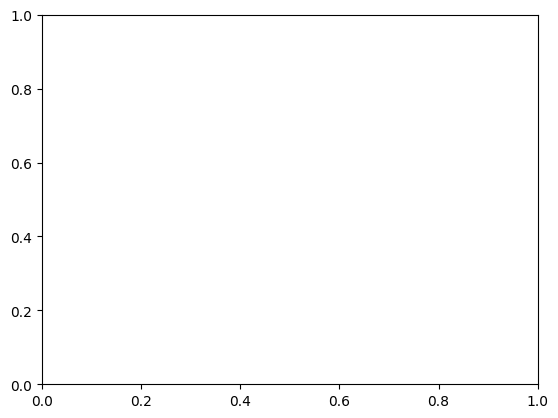

Score : [0.9999232292175293]


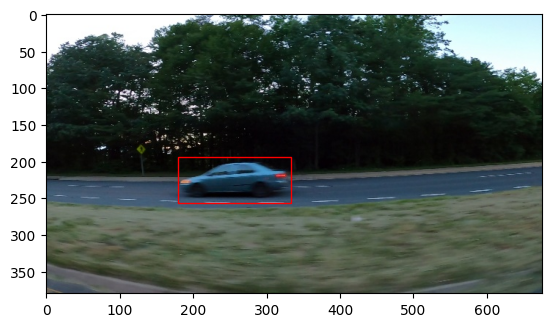

In [17]:
for i in range(5):
    next(preds)

In [18]:
import pickle 
filehandler = open("/kaggle/working/cars_model.pkl", 'wb') 
pickle.dump(cars, filehandler)

In [19]:
# import pickle 
# with open("/kaggle/working/eval.pkl" , 'rb') as f:
#     rs = pickle.load(f)